In [97]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import cv2
import os

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [98]:
img_size = (224,224)
data_path = "PlantVillage"

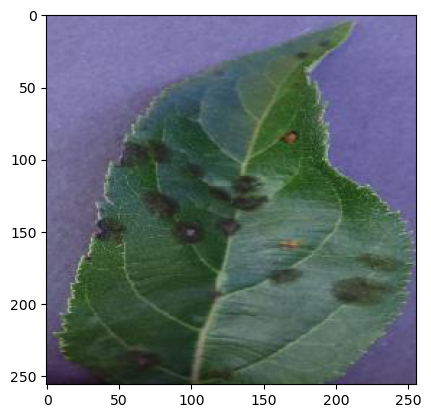

In [102]:
image = plt.imread("PlantVillage/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG")
plt.imshow(image)

In [99]:
classes = os.listdir(os.path.join(data_path,"train"))

# All classes

In [100]:
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'background',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',


# Data before balencing

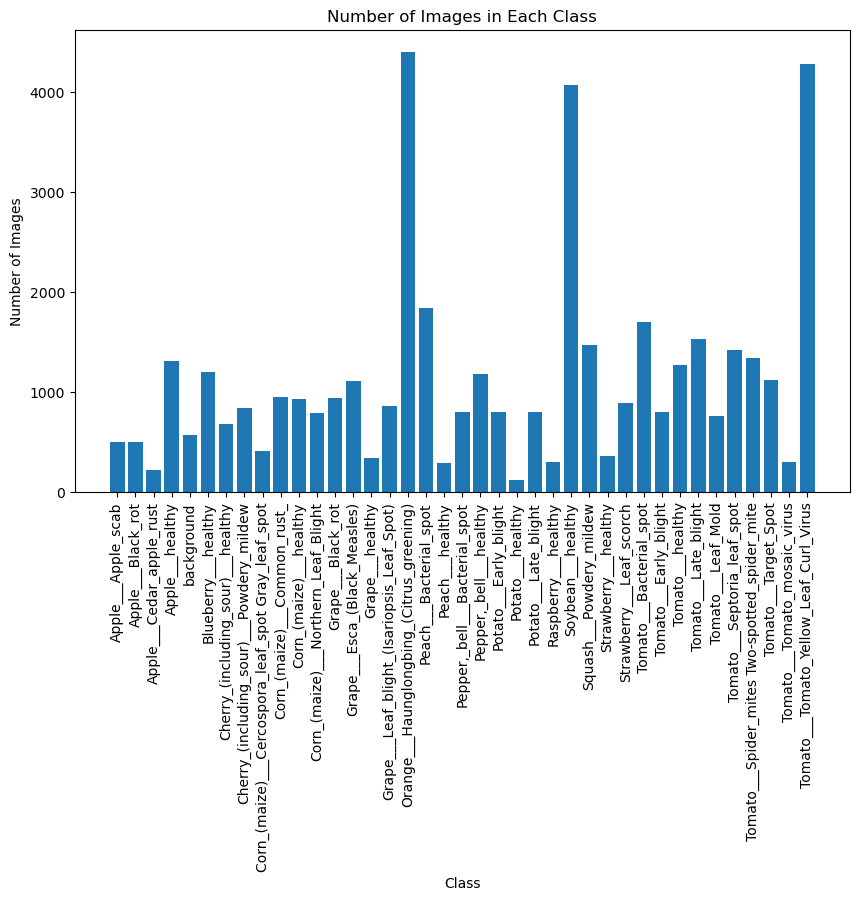

In [107]:
import os
import matplotlib.pyplot as plt

dataset_path = 'PlantVillage/train'

class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))


plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90) 
plt.title('Number of Images in Each Class')

plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)


plt.show()

# 2 - Balencing data

In [110]:
from PIL import Image, ImageEnhance, ImageOps
import os
import random
import math

## a - Randomly scale and rotate data 

In [103]:
def random_rotate_and_scale(image):
    rotation_angle = random.randint(-7,7)

    rotated_image = image.rotate(rotation_angle, expand=True, fillcolor='white')

    scale_factor = 1 + abs(rotation_angle) * 0.02 

    new_size = (int(rotated_image.width * scale_factor), int(rotated_image.height * scale_factor))
    scaled_image = rotated_image.resize(new_size, Image.ANTIALIAS)

    original_size = image.size 
    left = (scaled_image.width - original_size[0]) // 2
    top = (scaled_image.height - original_size[1]) // 2
    right = (scaled_image.width + original_size[0]) // 2
    bottom = (scaled_image.height + original_size[1]) // 2

    return scaled_image.crop((left, top, right, bottom))

## b - Random color shift

In [104]:
def random_color_shift(image):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(random.uniform(0.5, 1.5))

## c - Random flip

In [ ]:
def random_flip(image):
    if random.random() > 0.5:
        return ImageOps.flip(image)
    else:
        return ImageOps.mirror(image)

## d - Random contrast

In [ ]:
def random_contrast(image):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(random.uniform(0.5, 1.5))

## Apply all transformations on image 

In [108]:
def apply_transformations(image ,aug_size):
    transformers = [random_rotate_and_scale, random_color_shift, random_flip, random_contrast]
    augmented_images = []
    for _ in range(aug_size):
        aug_image = image.copy()
        for t in random.sample(transformers, len(transformers)):
            aug_image = t(aug_image)
        augmented_images.append(aug_image)
    return augmented_images

In [130]:
folder_path =  os.path.join("PlantVillage","train")

for class_name in classes:
    class_path = os.path.join(folder_path, class_name)
    
    if class_counts[class_name] < 4000:
        aug_size = int(5000 // class_counts[class_name])

        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(class_path, filename)
                img = Image.open(img_path)

                augmented_images = apply_transformations(img, aug_size)
                for i, aug_img in enumerate(augmented_images):
                    aug_img.save(os.path.join(class_path, f'aug_{i}_{filename}'))
                

C:\Users\wailb\AppData\Local\Temp\ipykernel_15092\2392834155.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  scaled_image = rotated_image.resize(new_size, Image.ANTIALIAS)


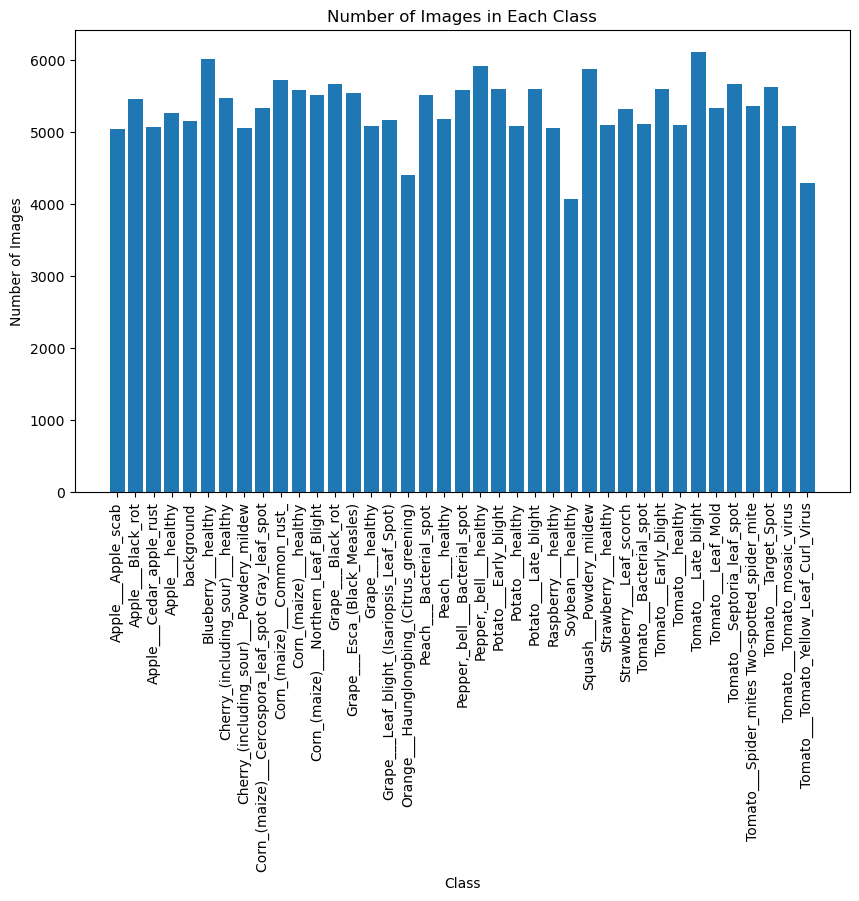

In [131]:
import os
import matplotlib.pyplot as plt

dataset_path = 'PlantVillage/train'

class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))


plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90) 
plt.title('Number of Images in Each Class')

plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)


plt.show()

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# Create data generators without augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have multiple classes
    classes=classes
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

Found 44016 images belonging to 39 classes.
Found 11004 images belonging to 39 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [58]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=(224,224, 3) ))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(39))

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 256)      

In [60]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [61]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/20
  1/343 [..............................] - ETA: 1:05:47 - loss: 8.6012 - categorical_accuracy: 0.0156

KeyboardInterrupt: 

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard


log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)

model = Model(inputs=base_model.input, outputs=x)


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras.layers import Dense

num_classes = len(classes)

x = Dense(256, activation='relu')(model.output)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)


In [65]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [68]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[tb_callback]
)

Epoch 1/20
343/343 [==============================] - 2100s 6s/step - loss: 2.8275 - accuracy: 0.2640 - val_loss: 2.5576 - val_accuracy: 0.3090
Epoch 2/20
343/343 [==============================] - 2337s 7s/step - loss: 2.3867 - accuracy: 0.3503 - val_loss: 2.2333 - val_accuracy: 0.3853
Epoch 3/20
343/343 [==============================] - 2249s 7s/step - loss: 2.1428 - accuracy: 0.4051 - val_loss: 2.0448 - val_accuracy: 0.4199
Epoch 4/20
343/343 [==============================] - 2024s 6s/step - loss: 1.9826 - accuracy: 0.4434 - val_loss: 1.9295 - val_accuracy: 0.4381
Epoch 5/20
343/343 [==============================] - 2025s 6s/step - loss: 1.8613 - accuracy: 0.4739 - val_loss: 1.8129 - val_accuracy: 0.4761
Epoch 6/20
343/343 [==============================] - 2025s 6s/step - loss: 1.7680 - accuracy: 0.4968 - val_loss: 1.7290 - val_accuracy: 0.5130
Epoch 7/20
343/343 [==============================] - 2026s 6s/step - loss: 1.6911 - accuracy: 0.5178 - val_loss: 1.6670 - val_accuracy:

In [17]:
model.save('PDResnet50-ep20.keras')

In [22]:
loaded_model = tf.keras.models.load_model('PDResnet50-ep24.keras')

In [19]:
loaded_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=2,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[tb_callback],
    verbose=1
)

Epoch 1/2


343/343 [==============================] - 1999s 6s/step - loss: 1.2268 - accuracy: 0.6365 - val_loss: 1.2650 - val_accuracy: 0.6278
Epoch 2/2
343/343 [==============================] - 2046s 6s/step - loss: 1.2100 - accuracy: 0.6409 - val_loss: 1.2136 - val_accuracy: 0.6281


In [23]:
model.save('PDResnet50-ep24.h5')

C:\Users\wailb\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import tensorflow as tf
print(tf.__version__)


2.15.0
